<a href="https://colab.research.google.com/github/NeelKanwal/BERTOLOGY-Based-Extractive-Summarization-for-Clinial-Notes/blob/master/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using Huggingface Library to get tokenizer and pretrained BERT model.

In [357]:
!pip install transformers
!pip install jsonlines

In [405]:
# Checking wether we have GPU to process tensors 
import torch
cuda_flag = torch.cuda.is_available()
if cuda_flag:
    device = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(device)
print('current device = '+device_name)

current device = Tesla P4


In [0]:
# loading 100 summaries for test
import jsonlines as js
# book = []
# with js.open("notes_labeled_dev.ndjson") as reader:
#   num = 0
#   for summary in reader:
#     if num<100:
#         book.append(summary[2])
#         num = num + 1

# clinical_notes = [" ".join( sum(book[i],[])) for i in range(100)]
Book=[]
with js.open('notes.ndjson','r') as reader:
    num = 0
    for summary in reader:
      if num<100:
        Book.append( summary)
        num = num + 1 

In [407]:
# with js.open('notes.ndjson','r') as reader:
#   count = 0
#   for summary in reader:
#     count = count +1
# print(count)

130


In [0]:
clinical_notes = [Book[i][2] for i in range(100)]

In [0]:
# # clinical_notes[0]
# for lst in clinical_notes[0]:
#   print(*lst)

In [0]:
# from transformers import BertModel, BertTokenizer # base bert

In [0]:
#clincalBert model with pre-treained weights
global model
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

In [0]:
def find_stats(note):
    padsize=0
    listsize=0
    pos,pos_longestsentence=0,0
    for lst in note:
        listsize+=1
        padsize=max(padsize,len(lst))
        if len(lst)==padsize:
            pos_longestsentence=pos
            pos+=1  
    print('Size of maximum string is ',padsize)
    print('Total number of lists ',listsize)
    print('Longest Sentence is at index ',pos_longestsentence)
    return (padsize,listsize,pos_longestsentence)


In [416]:
(pad_size,_,_) = find_stats(clinical_notes[0])
print(pad_size)

Size of maximum string is  40
Total number of lists  214
Longest Sentence is at index  9
40


In [0]:
from torch.nn.utils.rnn import pad_sequence
if cuda_flag:
    model = model.cuda()
model.eval();

In [0]:
#attentions is a tuple of lists [0-12] are layers. we choose layer 2. Last layers focus all attention on CLS token
import numpy as np
def find_attentions(summary):
    input_text=[]
    for lst in summary:
      input_text.append(tokenizer.encode_plus(lst,add_special_tokens=True,return_tensors='pt')) # ecnode
    # do padding to make all sentences equal for BERT
    tensor_text = pad_sequence([item['input_ids'].squeeze(0) for item in input_text], batch_first=True)
    tensor_mask  = pad_sequence([item['attention_mask'].squeeze(0) for item in input_text], batch_first=True)
    tensor_ids = pad_sequence([item['token_type_ids'].squeeze(0) for item in input_text], batch_first=True) 

    if cuda_flag:
         tensor_text, token_type, attention_mask = tensor_text.cuda(), tensor_ids.cuda(), tensor_mask.cuda()
      
    with torch.no_grad():
        # loss,logits,attentions = model(tensor_text, token_type_ids = token_type, attention_mask = attention_mask)
            attentions = model(tensor_text, token_type_ids = token_type, attention_mask = attention_mask)[-1]
        # final_score=attentions[11].mean(axis=0).mean(axis=0).cpu().numpy()
            final_score  =[np.max(attentions[sen][:].cpu().numpy()) for sen in range(attentions.shape[0])]
            final_score = [0 if i<0 else i for i in final_score]
            score_norm=[i/sum(final_score) for i in final_score] 
    return final_score
        # seq_score=[]
        # for r in range(0,len(summary)):
        #       seq_score.append(final_score[r][0])
        # print(seq_score) 
        # print(len(seq_score))
        # return seq_score

#  print(attentions[11].cpu().numpy().shape)
#[hidden_State][Attention_head][Sentenceces][attention_score_from_word_in_sentence]


In [0]:
import statistics as sc

def extract_bert_summary(summary):
  attentions = find_attentions(summary)
  lengths=[len(lst) for lst in summary]
  score=[[a]*leng for a,leng in zip(attentions,lengths)]
  score = sum(score,[])
  words = [word  for sentence in summary for word in sentence]
  extraction = [word for (word,attention) in zip(words,score) if float(attention) > sc.mean(attentions)]
  return extraction

In [0]:
summary_clinical_notes = [extract_bert_summary(note) for note in clinical_notes]

In [422]:
len(summary_clinical_notes)

100

In [0]:
#Evaluation Criteria Based on probabilty distribution hypothesis sripada et al .
from scipy.stats import entropy
from scipy.spatial import distance

from collections import Counter
from collections import OrderedDict

def kld(summ, org): 
        dist_original=Counter(str(org).lower().split())
        dist_summary=Counter(str(summ).lower().split())
        q = list(dist_original.values())
        p=list(dist_summary.values())
        a=min(len(p),len(q))
        return entropy(p[0:a],qk=q[0:a])
 
def jsd(summ,org):
        dist_original=Counter(str(org).lower().split())
        dist_summary=Counter(str(summ).lower().split())
        p = list(dist_original.values())
        q = list(dist_summary.values())
        a=min(len(p),len(q))
        return distance.jensenshannon(p[0:a],q[0:a])

In [427]:
import statistics as sc
kld_bert=[]
jsd_bert = []

for i in range(100):
  kld_bert.append(kld(summary_clinical_notes[i],clinical_notes[i]))
  jsd_bert.append(jsd(summary_clinical_notes[i],clinical_notes[i]))

print(sc.mean(kld_bert))
print(sc.mean(jsd_bert))

0.7954174553744477
0.4055822997661006


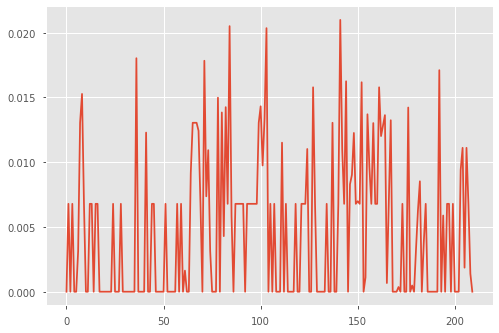

In [428]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.plot(attentions)

(array([105.,   4.,   4.,  53.,   6.,  10.,  16.,   6.,   3.,   3.]),
 array([0.        , 0.00209888, 0.00419776, 0.00629664, 0.00839553,
        0.01049441, 0.01259329, 0.01469217, 0.01679105, 0.01888993,
        0.02098881]),
 <a list of 10 Patch objects>)

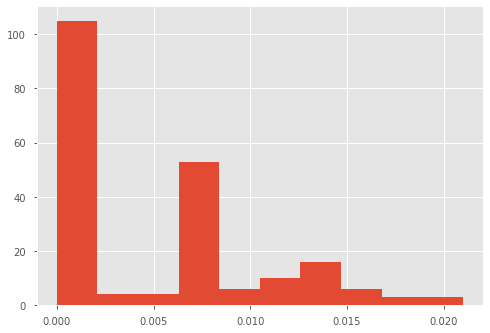

In [429]:
plt.hist(attentions,bins=10)

In [0]:
# values from other notebook baselines summarizer
kld_graph = [0.7300056898789489, 1.1694653021133752, 0.6582040562369684, 1.1142263603662046, 0.8318529166860184, 0.8500070481335991, 0.7234898358384443, 0.9397794415946781, 0.726998247614633, 0.8241942675835762, 0.7265543565505864, 0.8975525931393504, 0.7959301455554484, 0.669376027852106, 0.6923054576777433, 0.8430866798024049, 0.8197445230302883, 1.1839705218869996, 0.6701176466628493, 0.6287766841898392, 0.8159473750157457, 0.756643590754108, 0.6906630843858031, 0.8931309728288316, 0.7144985447747672, 0.8300907000246323, 0.834051631125655, 0.37818748694309756, 0.7661089260302357, 0.5496976276423745, 1.1552599696350314, 1.1139611998440782, 0.9708535963995211, 0.7248635204961643, 0.7987247104279331, 1.0527604136198216, 0.4291175146466038, 0.8817568712791295, 0.977064960959994, 0.8256685296408494, 1.1179781921775627, 1.0158723379775443, 0.6275512853238936, 0.889559830760793, 0.86616539695137, 1.015695888958109, 0.9623901921279748, 0.7535301262975973, 0.6733909419467383, 0.9915513212639595, 0.8950265190593789, 0.7367017095195311, 0.7066241697163015, 0.6304186629758641, 0.6266687545556131, 0.9350300679640836, 0.74445164581268, 0.7132363218902187, 0.899419062924438, 0.9041153125555343, 0.9170253626463758, 0.6777954225459047, 0.6796064196331952, 0.359659861346278, 0.9685228897871683, 0.6872233912545257, 0.9461190163563672, 1.0868593983885828, 0.7128740045675543, 0.7082165618844374, 1.0283505192174982, 0.9770303398102115, 0.9490783233675888, 0.8073872415005704, 0.7649776078191046, 0.7957951660901631, 0.9871173285269387, 0.7410403254178912, 0.6508963809634369, 0.6687174339884687, 0.859265556947042, 0.6807309559224896, 0.9393438592692173, 0.8344844075404826, 0.9832039818569783, 0.6087414672046543, 0.8236330442677694, 0.6797628587297387, 1.235382614666698, 1.1498393769142612, 1.2362334632243672, 0.8164423782212614, 0.8693744754909798, 0.7759678551566488, 0.6634608403603763, 0.41685744869339164, 0.7343632141394312, 0.8113064916022634, 1.0262722025876216, 1.1032334934986978]
jsd_graph =[0.40572689452868865, 0.4813096599104728, 0.37274724920541863, 0.45182646849647046, 0.40472723442093994, 0.40754138115633826, 0.38633816629952566, 0.44705624592014304, 0.38367956612670323, 0.4002275883011303, 0.38695315477095393, 0.4187542103541375, 0.40496211598474424, 0.3786508981574111, 0.39717680492744994, 0.40603010429191005, 0.408283973678661, 0.4630105396718603, 0.39274058754513985, 0.3650499782321273, 0.402852165926118, 0.3895585816063566, 0.38845019714391726, 0.4339320594852482, 0.38324987845709724, 0.4039121630728288, 0.420325557946207, 0.2852786702376886, 0.38939581774561316, 0.3369839680655799, 0.46756818119396004, 0.45102940006711667, 0.4566893658812188, 0.386086126785046, 0.39323318162638926, 0.454530816023426, 0.30564345489761596, 0.41733044276279113, 0.45711090061982, 0.4066859195027178, 0.44548471361302966, 0.43001762002444993, 0.3664051800776602, 0.4179066338522689, 0.40804220666223107, 0.46284453146823484, 0.4310261492958148, 0.40493105877435837, 0.3638919214040496, 0.4429928642348839, 0.4276018606833262, 0.39129857365429793, 0.3815681844283498, 0.38290473557663934, 0.36745650365594523, 0.4273650590136626, 0.38773786771474034, 0.38702673306663693, 0.43701637827249645, 0.42669922878383876, 0.4414503565319712, 0.37577487102431545, 0.38371169279552236, 0.28754965702747015, 0.4348691790765962, 0.3754683688074647, 0.44284742084782436, 0.4571780958152055, 0.4051255731165885, 0.3935463398267229, 0.4686754278898076, 0.4499906349221446, 0.43104858078926567, 0.4049067128869286, 0.4101693300689571, 0.40055983664753536, 0.44563792702026545, 0.4115244288142892, 0.3875719847411568, 0.37650062039087717, 0.41643653043166867, 0.3863212113503817, 0.42718551235921753, 0.4167799751288987, 0.44608095400179404, 0.3615201533362695, 0.42967611050141646, 0.3849967713028161, 0.48370776707941016, 0.4832681474441424, 0.46856414784481426, 0.4133377448026442, 0.42057139142854527, 0.3879822334781606, 0.37566998952090147, 0.30391310914144126, 0.3836765924085119, 0.4046502018118133, 0.45583436111455644, 0.4549496473633336]

In [0]:
kld_freq = [0.7199990163091441, 1.288577094003375, 0.6876781653361953, 1.0548275305953054, 0.822106467044532, 1.0250455035798383, 0.7642230697261388, 0.8861677097328216, 0.8133151448774971, 1.070300835591361, 0.8902506584557677, 1.0409563178920767, 0.9325518447723371, 0.876780478796326, 0.7527658673801978, 1.109862192707198, 0.9814609731836896, 1.3140823138880307, 0.6336290837851819, 0.5945883813485552, 0.9853710957839535, 0.6425021501485686, 0.7927687220316615, 1.0248072650693685, 0.7909853199013283, 0.917756720574602, 0.7840406497243342, 0.36351808643481, 0.7646289844561274, 0.7901441270581637, 1.3074442360423464, 1.1585353169123405, 0.8390222886295955, 0.7277708334637526, 0.9440759880626365, 1.0119889895584742, 0.4404568982928508, 0.809263712380167, 0.9257424674505709, 0.8088068380486474, 1.1703079980729523, 1.0009809316501646, 0.6645238775763517, 0.9657224564406461, 0.8211600933863579, 0.9475945948239577, 1.0045711656352914, 0.8222920904678139, 0.9173348150335361, 1.0650339501847848, 0.9150650487002507, 0.8592161332260143, 0.7760992513052745, 0.9899705820711331, 0.25402090348903744, 1.0738141312402973, 0.958779532547603, 0.8047759506636604, 0.8837316319163978, 1.0237833505131568, 1.0448370196047883, 0.7598523168375311, 0.7421577154953737, 0.7060657854315938, 0.9310896222377714, 0.7222608882096487, 1.0117940181455518, 1.235252849808724, 0.7749524468673616, 0.6028963762294497, 0.8497471330550408, 1.188247565159837, 1.1064630436808665, 0.8005052123107964, 0.943394967833588, 0.8352263506528074, 1.261395619257123, 0.9057660069747315, 0.7437664404687891, 0.8961443246169718, 0.992520711484797, 0.9310731755674274, 0.8276231800837823, 0.8482506953980145, 0.951658753833869, 0.6529169649183043, 0.6827022343894, 0.8240654539174791, 1.3381892931093735, 0.8883881871861411, 1.3539373370730008, 0.7983410280939688, 0.7374364832394635, 0.841450466192277, 0.7601875735059431, 0.49707873253014384, 0.8610639835107452, 1.0040131802807752, 1.244057337071036, 1.1587067148922152]
jsd_freq = [0.39720931225497386, 0.4852511366314636, 0.3872706804927176, 0.46340325681824046, 0.4099997986976341, 0.46005880733558646, 0.4002969489882648, 0.44234415036007135, 0.421925310099122, 0.4693768278740044, 0.4158760771563454, 0.45895034411578084, 0.4402055982830778, 0.41583161778047406, 0.3969658596406603, 0.4911221113095487, 0.445479559429233, 0.5046759063512024, 0.3713131621866397, 0.3478467357335101, 0.4340713440256459, 0.3749889088313121, 0.41151153011543545, 0.4588922511707417, 0.4091819540392327, 0.43419640905267, 0.4065440662077568, 0.2844284268589189, 0.40559652794340256, 0.4014378102932751, 0.4967820570737719, 0.4870344672921085, 0.4078101320044515, 0.4108891690505209, 0.43240798520967044, 0.44935119240437205, 0.30652719506018367, 0.4162684644669471, 0.4354268177375234, 0.39773859743967266, 0.4715521382530961, 0.447962003273332, 0.38610627249095786, 0.4315213182615697, 0.41408626881185323, 0.44327199859245164, 0.44658865113350443, 0.40915999634888267, 0.432579406441209, 0.46516287510699234, 0.43411307155006607, 0.4231658229357147, 0.3998127104906795, 0.45057579185007557, 0.2290297743715948, 0.4760834031030112, 0.4335523857629184, 0.41516752657671646, 0.43874027686937406, 0.4568945731781437, 0.47081245798217464, 0.4056472661746331, 0.3979407366977592, 0.37717446499159896, 0.4340829736581772, 0.3881235315133434, 0.44593482069341067, 0.4900066637617449, 0.4013769642616592, 0.3620793700689522, 0.42967583582364666, 0.5092855744997147, 0.4815715537389554, 0.4107153861102546, 0.4324135002174301, 0.41260020432057676, 0.47584168236171737, 0.45241197157420976, 0.39985777827917024, 0.44433796189167596, 0.4507521245052968, 0.43070964328348293, 0.4142477213322459, 0.4282527282335757, 0.4372838180953955, 0.37491735876279997, 0.3816171949760131, 0.42752970547470326, 0.4951776614304662, 0.43596184440374197, 0.5136152666821995, 0.41795562355788785, 0.4099793980911211, 0.4202847642635409, 0.4098869056748805, 0.32936378459450627, 0.4188613183589922, 0.4511300428259509, 0.48116143642937387, 0.4832579831809677]

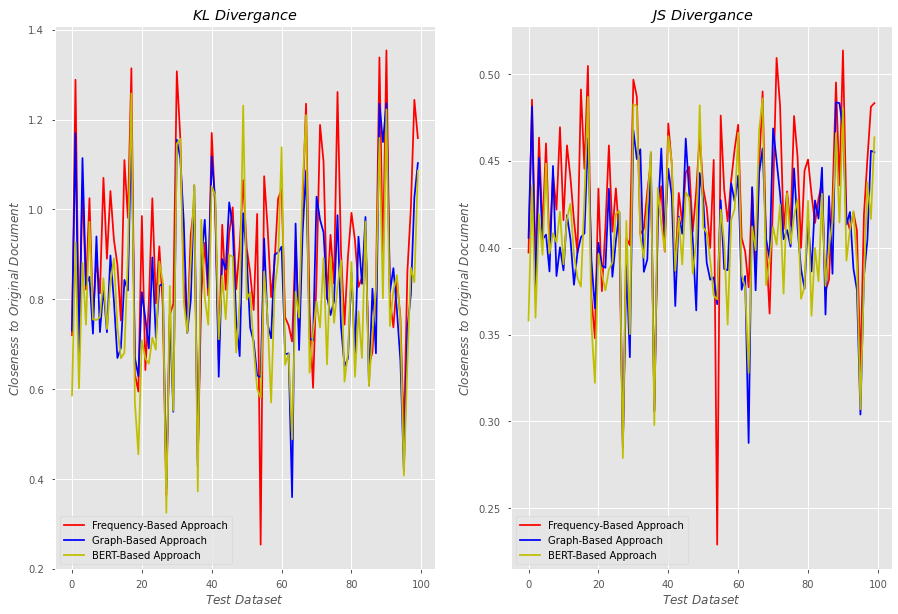

In [451]:
plt.figure(figsize=(15,10))

plt.subplot(121)
plt.style.use('ggplot')
plt.plot(kld_freq,'r',label= "Frequency-Based Approach")
plt.plot(kld_graph,'b',label="Graph-Based Approach")
plt.plot(kld_bert,'y',label="BERT-Based Approach")
plt.xlabel("$Test\ Dataset$")
plt.ylabel("$Closeness\ to\ Original\ Document$")
plt.title("$KL\  Divergance$")
plt.legend()


plt.subplot(122)
plt.style.use('ggplot')
plt.plot(jsd_freq,'r',label= "Frequency-Based Approach")
plt.plot(jsd_graph,'b',label="Graph-Based Approach")
plt.plot(jsd_bert,'y',label="BERT-Based Approach")
plt.xlabel("$Test\ Dataset$")
plt.ylabel("$Closeness\ to\ Original\ Document$")
plt.title("$JS\  Divergance$")
plt.legend()
plt.savefig("evaluation.jpg")
plt.show()


#Kolmogorov-Smirnov test
A goodness test to check wether the obtained distribution is as good as bell curve for visualization


In [104]:
from scipy.stats import kstest 
# import matplotlib.pyplot as plt
a,b = kstest(attentions, "norm",alternative='greater')    
# plt.style.use('seaborn-notebook')
# plt.plot(a)
print("Result from ",a)

Result from  0.4916272896170897


It distracts from normal distribution by nearly 50% which can be bad unnoticable for heat mapping, we need to do some stastical analysis to transform the distribution

#Power Transformations

Power transforms are a family of parametric, monotonic transformations that are applied to make data more Gaussian-like. This is useful for modeling issues related to heteroscedasticity (non-constant variance), or other situations where normality is desired.

There two possible transformations. 
1. Box-Cox Transformation
2. Yeo Johnson Transformation


In [0]:
import numpy as np
from scipy.stats import yeojohnson
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer

# pt = PowerTransformer(method='yeo-johnson')
# pt.fit_transform()
yeojohnson_scores = yeojohnson(attentions, 0)
pt = PowerTransformer()
power_scores = pt.fit_transform(np.array(attentions).reshape(-1, 1))
# alpha = 0.001
# # att = [float(i) +alpha  for i in attentions  if i=0 else i  ] # bacuse boxcox takes stricly positive values
# # boxcox_scores = boxcox(att,0.1)
# a=power_transform(np.array(seq_score).reshape(-1,1), method='box-cox')
# print(attentions)
# print(new_scores , end=" ")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


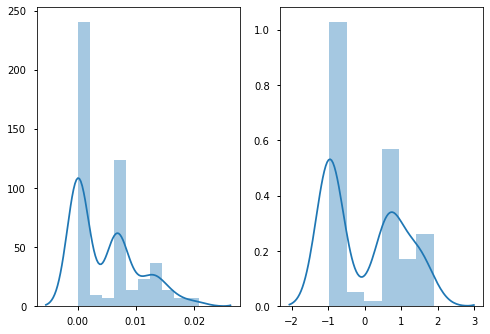

In [144]:
import seaborn as sns
fig, ax=plt.subplots(1,2)
sns.distplot(yeojohnson_scores, ax=ax[0])
sns.distplot(power_scores, ax=ax[1])

# For heat-mapping on neat-Vision

We tranform that data into normal distribution, we can see from previous graphs that data is multinomial and it may be unsuitable for extracting summary or putting out scores of Neat-Vision. Moreover, Neat has an specific method of procession data in json.

https://github.com/cbaziotis/neat-vision

dictionary of text,label,prediction,posteriori(optional),attention,id.

In [0]:
from sklearn.preprocessing import QuantileTransformer
from functools import reduce

qt = QuantileTransformer(n_quantiles=10, random_state=0,output_distribution='normal')
quantile_scores = qt.fit_transform(np.array(attentions).reshape(-1,1)).squeeze(1)
# quantile_scores_norm=[float(i)/sum(quantile_scores) for i in quantile_scores]
quantile_scores =  [0 if i<0 else i for i in quantile_scores]
quantile_scores_norm=[float(i)/sum(quantile_scores) for i in quantile_scores]
# quantile_scores = [value.tolist() for value in quantile_scores if type(value) == np.ndarray]

In [0]:
import json
import pandas as pd
def create_neat_vision_file(summary,scores):
      data={}
      data['text']= sum(summary, [])
      data["label"] = 0
      data["prediction"] = 0
      lengths=[len(lst) for lst in summary]
      att=[[a]*leng for a,leng in zip(scores,lengths)]
      data['attention']=sum(att,[])
      # print(data['attention'])
      # print(len(data['attention']))
      # print(len(data['text']))
      data["id"]="sample"
      # paging restructure into 10 words per line 
      newdata=[]
      
      for a in range(0,len(data['attention']),10):
        newdict={}
        newdict["text"]=(data["text"][a:a+10])
        newdict['label'] = 0
        newdict["prediction"] = 0
        newdict["attention"]=data['attention'][a:a+10]
        newdict["id"] = "sample_%d"%a
        newdata.append(newdict)

      with open('quantile_clincalbert.json','w') as out:
            out.write(json.dumps(str(newdata),indent=1))

In [263]:
create_neat_vision_file(clinical_notes[0],quantile_scores)

[0, 0, 0.28221614706250825, 0, 0, 0.28221614706250825, 0, 0, 0, 0, 0, 0, 0, 0, 1.2206403488473496, 1.2206403488473496, 1.4052854609640888, 0.28221614706250825, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.28221614706250825, 0.28221614706250825, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.28221614706250825, 0.28221614706250825, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.28221614706250825, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.28221614706250825, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.7348296120914874, 1.7348296120914874, 1.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: The parameter where must have the same size as x in fill_between(). This will become an error in future versions of Matplotlib.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: The parameter where must have the same size as x in fill_between(). This will become an error in future versions of Matplotlib.
  # This is added back by InteractiveShellApp.init_path()


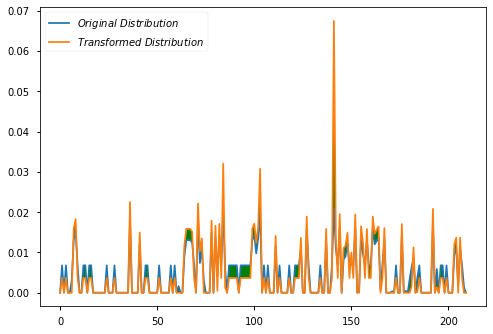

In [254]:
# difference that Quantile Transform brings
import matplotlib.pyplot as plt
import numpy as np


dist_a=attentions
dist_b=quantile_scores_norm
xaxis = np.arange(0,min(len(dist_a),len(dist_b)))
plt.plot(xaxis, dist_a , label = "$ Original\ Distribution$")
plt.plot(xaxis, dist_b , label = "$Transformed\ Distribution$")
plt.fill_between(xaxis, dist_a, dist_b, where=dist_b>=dist_a, facecolor='red', interpolate=False)
plt.fill_between(xaxis, dist_a, dist_b, where=dist_b<=dist_a, facecolor='green', interpolate=False)
plt.legend()
plt.savefig("QuantileTransform.jpg")
plt.show()